### Goals for the week of March 3rd.

1. Bid/No Bid model (per company)
Equinor, 2016- onwards (top few largest players by number of blocks bid on). 

5- most active.

p(bid|company)

2. Bid Amount (per company)

As above. 


1. Can machine learning be used to predict lease sales (with open data)?

2. How much better can a model be with further information/feature engineering/prop data?

3. Other applications to get this up and running, experience how to.






In [1]:
from os.path import dirname, join
from elvis.visualization.utils import load_dash_data, slice_by_area
from elvis import datasets
from elvis.io.boem_from_file import (boem_leases,
                                     boem_lease_by_owner,
                                     get_neighbourhood_leases, 
                                     get_blocks, 
                                     read_curated_neighbourhoods,
                                     freeze_bids,
                                     load_num_wells,
                                     boem_platform_structures)

from elvis.visualization.mapping import (bathymetry_underlay,
                                         create_map_from_geojson,
                                         colors as company_colors,
                                         geojson_underlay)

from elvis.model.backtesting import BidData, KernalAvgByBlock, LeaseBasedFeatures, explanatory_vars

import geopandas as gpd
import numpy as np
import pandas as pd
import tqdm

base_directory = dirname(datasets.__file__)
freeze_data = join(base_directory, 'Freeze_Data\ 12_4_2019')

# figure out a "20m arc length but in radians"
EARTH_RADIUS_M = 1000*6378.1
TEN_MILES = 10 * 1.6 *1000
TWENTY_MILES = 20 * 1.6 *1000

#
period_size = 'Q'
# date range for backtesting
date_range = pd.date_range(start=pd.datetime(2003,1,1), 
                           end=pd.datetime(2020,1,1), 
                           freq=period_size)
periods = date_range.to_period(period_size)
current_period = pd.Timestamp.now().to_period('Q')


In [2]:
blocks = get_blocks(base_directory)
blocks.set_index("AREABLK", inplace=True)

leases = boem_leases(base_directory)
leases.sort_index(inplace=True)
leases["Lease Effective Date"] = leases["Lease Effective Date"].dt.to_period(period_size)
leases["Lease Expiration Date"] = leases["Lease Expiration Date"].dt.to_period(period_size)
# drop bad data
leases.dropna(subset=["Lease Effective Date"], inplace=True)

wells = load_num_wells(base_directory)

qdata = pd.read_csv(join(base_directory, "Quarterly_ProdData.csv"))
qdata['Production Date'] = [pd.Period(i) for i in qdata['Production Date'].values]
qdata.set_index(["Lease Number", "Production Date"], inplace=True)

planning_areas = pd.read_csv(join(base_directory,"blocks_by_planningarea.csv"))
planning_areas.set_index("AREABLK", inplace=True)

bid_data, winning_bids, consortia = freeze_bids(freeze_data)
consortia.set_index(["AREABLK", "Lease Number"], inplace=True)

# only consider leases that have associated bids (edge cases)
_lease = winning_bids.merge(leases, how="inner", on=["AREABLK", "Lease Number"], right_index=True)
leases = _lease[leases.columns]

# infrastructure
platform_structures = boem_platform_structures(base_directory)
platform_structures["AREABLK"] = platform_structures["AREABLK"].str.replace("\W","")
platform_structures.dropna(subset=["AREABLK"], inplace=True)
platform_structures.set_index("AREABLK", inplace=True)
#
platform_structures["Install Period"] = platform_structures["Install Date"].dt.to_period(period_size)
platform_structures["Removal Period"] = platform_structures["Removal Date"].dt.to_period(period_size)

# object for dealing with averaging over neighbourhood
kde = KernalAvgByBlock(base_directory)


/Users/blasscock/.edm/envs/Equinor/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2874: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/Users/blasscock/.edm/envs/Equinor/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
all_blocks = blocks.index.values
# create generator of explanatory variables.
lbfs = {area_block:LeaseBasedFeatures(area_block=area_block, kde=kde) for 
                area_block in tqdm.tqdm(all_blocks)}

100%|██████████| 29102/29102 [01:08<00:00, 426.13it/s]


### Generate datasets
This is very slow, once you've got a set of explanatory variables, save the results to disk.

In [4]:
# save the result to disk so we can tweak models 
bd = BidData(bid_data=bid_data)
gen = bd.hold_auctions(leases)

period, _leases, mlot = next(gen)

for i, val in enumerate(bd.hold_auctions(leases)):
    period, _leases, mlot = val
    
    result = [explanatory_vars(lbfs[arr], _leases, bid_data, wells, qdata, platform_structures, period) for 
                         arr in tqdm.tqdm(mlot.index.get_level_values(0))]
    
    X, y = np.vstack(result), mlot["BID"].values
    
    # if we couldn't figure it out:
    indx = ~np.any(np.isnan(X), axis=1)
    X = X[indx,:]
    y = y[indx]
    
    # use the "i" index for the lease auction to reloade over time.
    np.save(join(base_directory, "model-1", "X-{}.npy".format(i)),X)
    np.save(join(base_directory, "model-1", "y-{}.npy".format(i)),y)
    mlot.to_csv(join(base_directory, "model-1", "bids-{}.csv".format(i)))


  4%|▍         | 23/545 [00:05<02:07,  4.10it/s]/Users/blasscock/.edm/envs/Equinor/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3242: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 147/147 [00:33<00:00,  4.36it/s]


In [5]:
features = [
"rolling_relinquished_well",
"rolling_relinquished",
"open_blocks",
"past_leases",
"current_leases",
"quarterly_production oil",
"quarterly_production condensate",
"quarterly_production gas_well_gas",
"quarterly_production oil_well_gas",
"platform_structures",
"wells",
"average_bid",
"high_bid",
"water depth"]

### Demo
Train three models, linear, log-linear and a random forest. The log-linear model is designed to suit the heavy tail. 

In [100]:
# Vanilla liner model
from sklearn.linear_model import LinearRegression,  BayesianRidge, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler

# loads  features from historical auctions.
_X = np.vstack([np.load(join(base_directory, "model-1", "X-{}.npy".format(i))) 
                    for i in range(24,32)])
_y = np.hstack([np.load(join(base_directory, "model-1", "y-{}.npy".format(i))) 
                    for i in range(24,32)])

# loads features from this auction.
_Xp = np.load(join(base_directory, "model-1", "X-{}.npy".format(32)))
_yp = np.load(join(base_directory, "model-1", "y-{}.npy".format(32)))
_mlot = pd.read_csv(join(base_directory, "model-1", "bids-{}.csv".format(32)))

# comparison forecasting
esa_forecast = pd.read_csv(join(base_directory, 
                                "ESA_bid_2009_2019.253_60_T", 
                                        "ESA_block_forecast.csv"))
esa_forecast.set_index("AREABLK", inplace=True)
esa_pred = esa_forecast.loc[_mlot["AREABLK"], "bidAmountE"].values

_X = np.ascontiguousarray(_X)
_y = np.ascontiguousarray(_y)

scaler = RobustScaler()
_X = scaler.fit_transform(_X)

/Users/blasscock/.edm/envs/Equinor/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


/Users/blasscock/.edm/envs/Equinor/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/blasscock/.edm/envs/Equinor/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


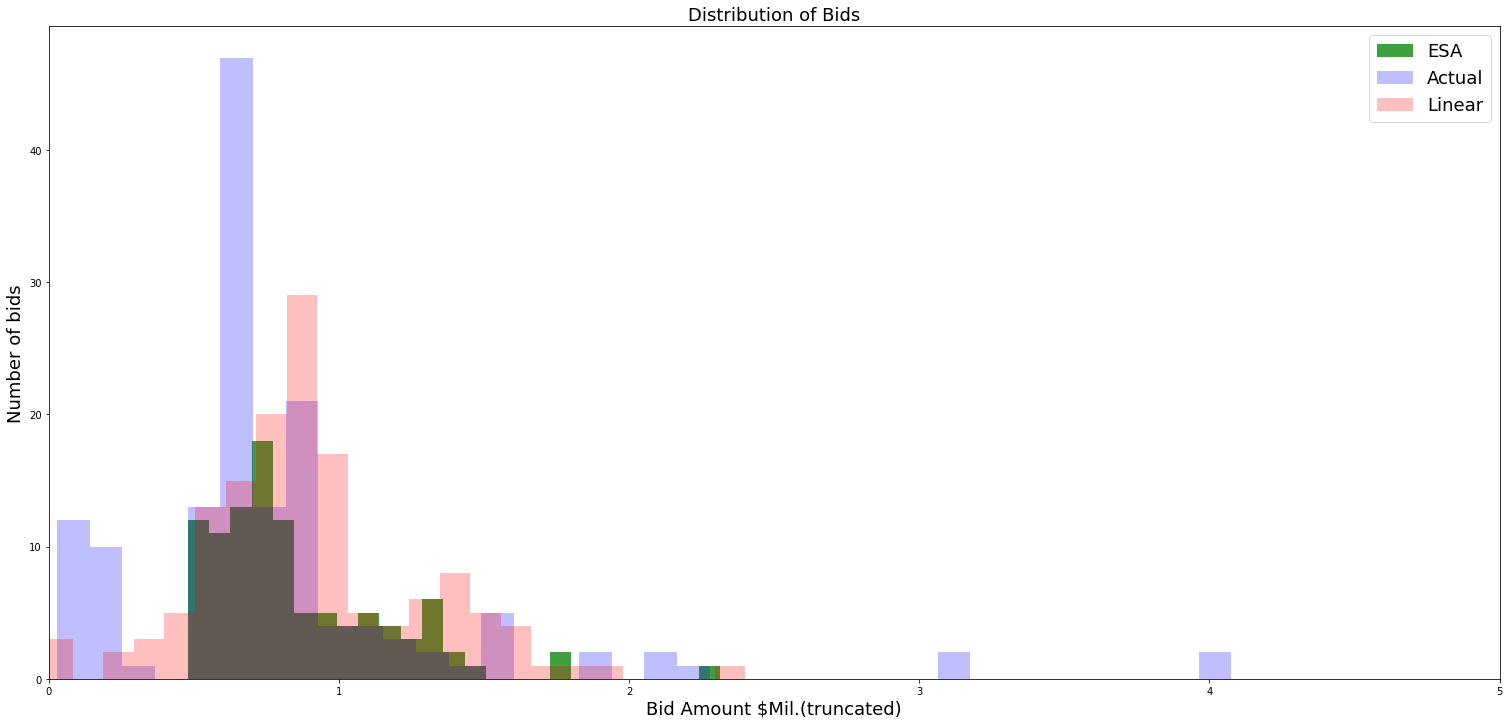

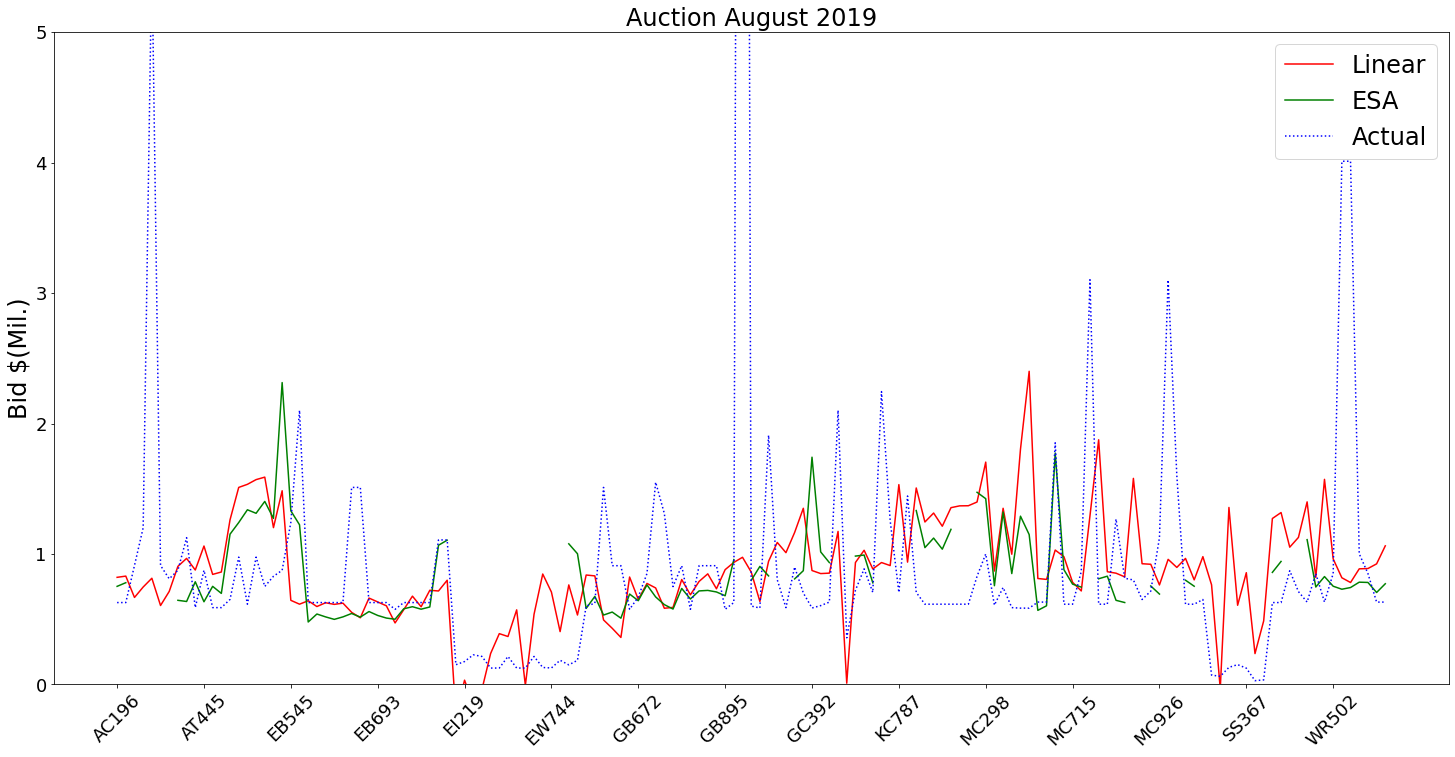

In [103]:
import matplotlib.pylab as plt

clf =  LinearRegression()
clf.fit(_X, _y)

plt.figure(figsize=(26,12))
plt.hist(esa_pred,25, alpha=0.75, color='green')
plt.hist(_yp/1E+6, 200, alpha=0.25, color='blue')
plt.hist(clf.predict(scaler.transform(_Xp))/1E+6,25, alpha=0.25, color='red')
plt.xlim([0,5])
plt.xlabel("Bid Amount $Mil.(truncated)", fontsize=18)
plt.ylabel("Number of bids", fontsize=18)
plt.title("Distribution of Bids", fontsize=18)
plt.legend(["ESA",  "Actual", "Linear"], fontsize=18)
plt.show()


fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

ax.plot(clf.predict(scaler.transform(_Xp))/1E+6, '-r')
ax.plot(esa_pred, '-g')
ax.plot(_yp/1E+6, ':b')

ax.set_ylim([0,5])
ax.set_xticklabels(_mlot["AREABLK"].values[::10], fontsize=18, rotation=45)
ax.set_xticks(np.arange(0,len(_mlot["AREABLK"]), 10))
plt.yticks(fontsize=18)
plt.ylabel("Bid $(Mil.)", fontsize=24)
plt.legend(["Linear","ESA","Actual"], fontsize=24)
plt.title("Auction August 2019", fontsize=24)
plt.show()

In [104]:
# min value per block
indx = _y > 1E+5
_Xln = _X[indx,:]
_yln = np.log(_y[indx] - 1E+5)

clfln =  LinearRegression()
clfln.fit(_Xln, _yln)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

/Users/blasscock/.edm/envs/Equinor/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/blasscock/.edm/envs/Equinor/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


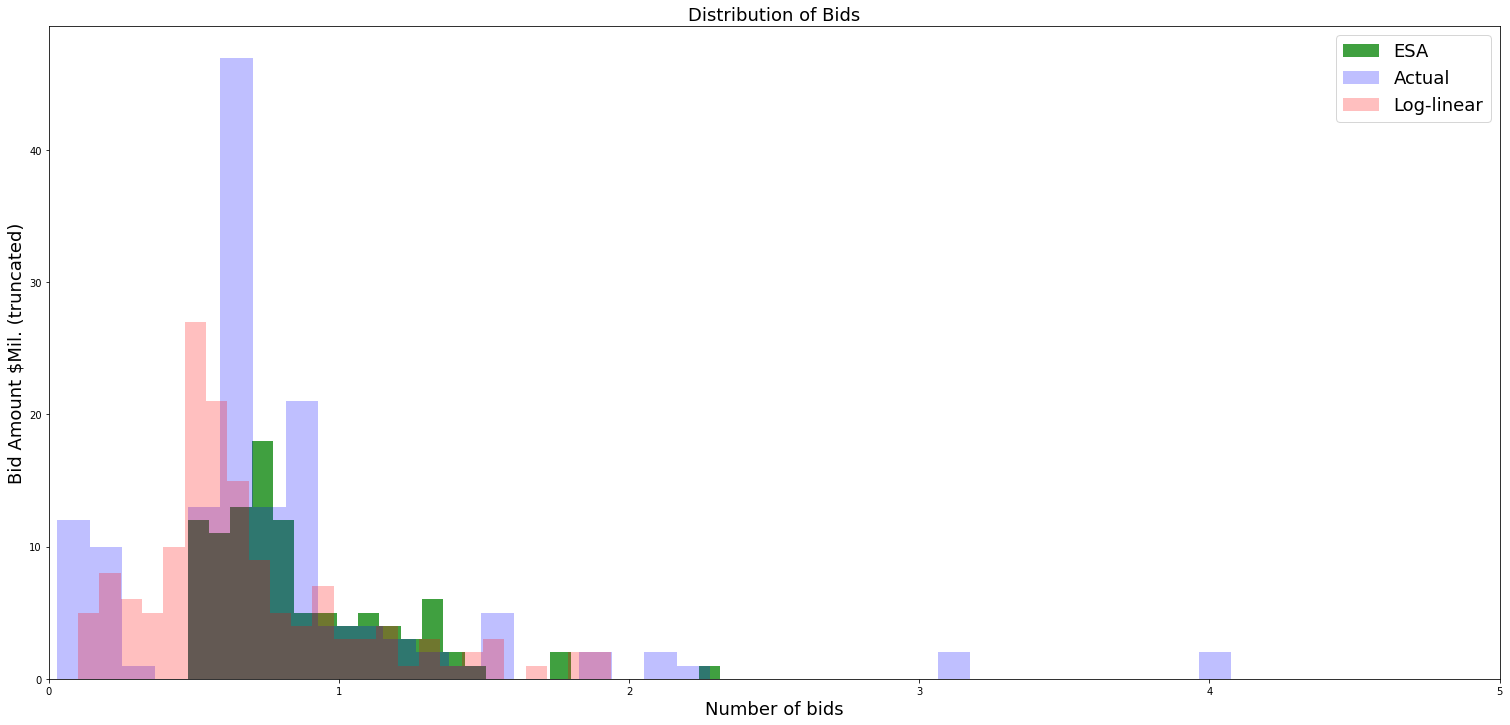

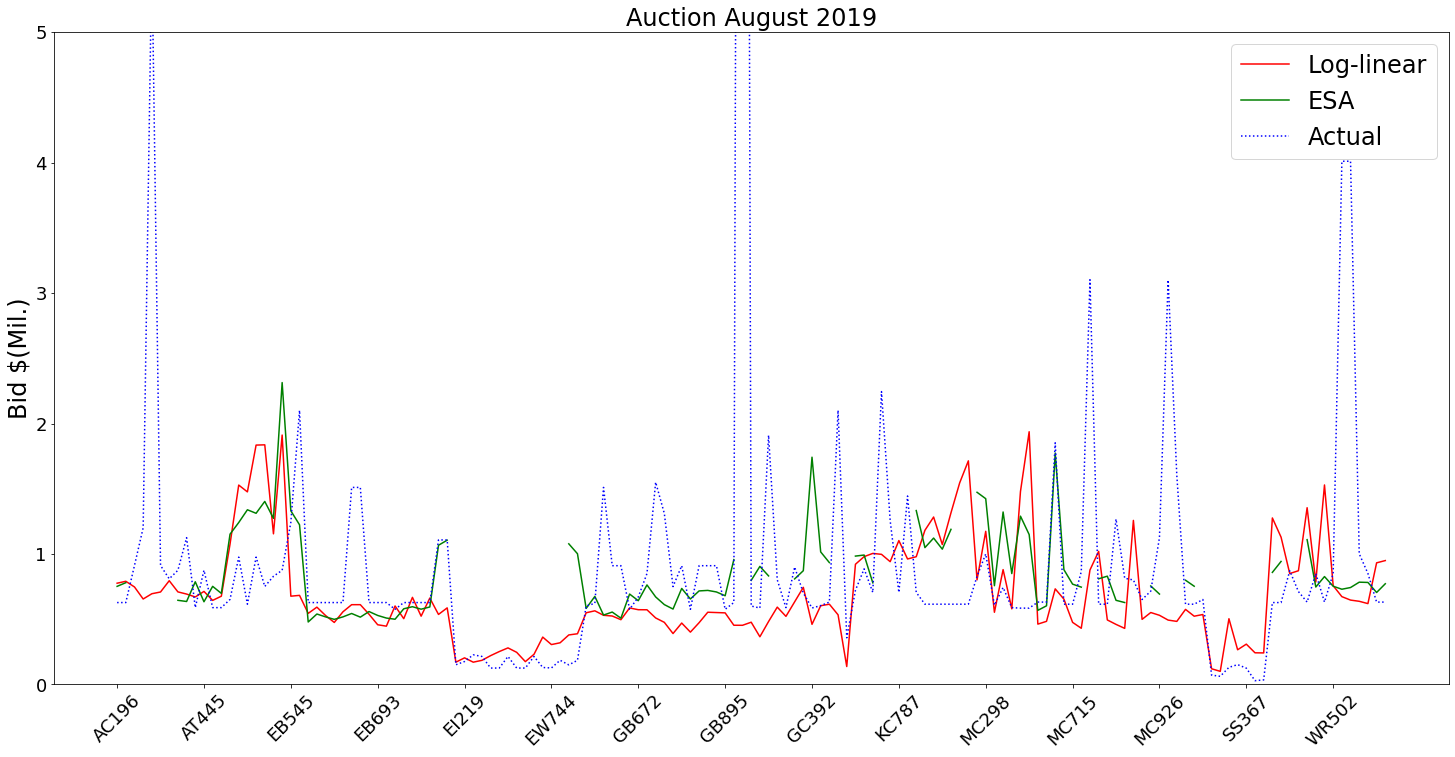

In [105]:
import matplotlib.pylab as plt

# we detrended it by the min value for the block
val = np.exp(clfln.predict(scaler.transform(_Xp))) + 1E+5

plt.figure(figsize=(26,12))
plt.hist(esa_pred,25, alpha=0.75, color='green')
plt.hist(_yp/1E+6, 200, alpha=0.25, color='blue')
plt.hist(val/1E+6,25, alpha=0.25, color='red')
plt.xlim([0,5])
plt.xlabel("Number of bids", fontsize=18)
plt.ylabel("Bid Amount $Mil. (truncated)", fontsize=18)
plt.title("Distribution of Bids", fontsize=18)
plt.legend(["ESA",  "Actual", "Log-linear"], fontsize=18)
plt.show()


fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

ax.plot(val/1E+6, '-r')
ax.plot(esa_pred, '-g')
ax.plot(_yp/1E+6, ':b')

ax.set_ylim([0,5])
ax.set_xticklabels(_mlot["AREABLK"].values[::10], fontsize=18, rotation=45)
ax.set_xticks(np.arange(0,len(_mlot["AREABLK"]), 10))
plt.yticks(fontsize=18)
plt.ylabel("Bid $(Mil.)", fontsize=24)
plt.legend(["Log-linear","ESA","Actual"], fontsize=24)
plt.title("Auction August 2019", fontsize=24)
plt.show()

In [106]:
clfrf = RandomForestClassifier(random_state=42)
clfrf.fit(_X.astype(np.float32), _y.astype(np.float32))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

/Users/blasscock/.edm/envs/Equinor/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/blasscock/.edm/envs/Equinor/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


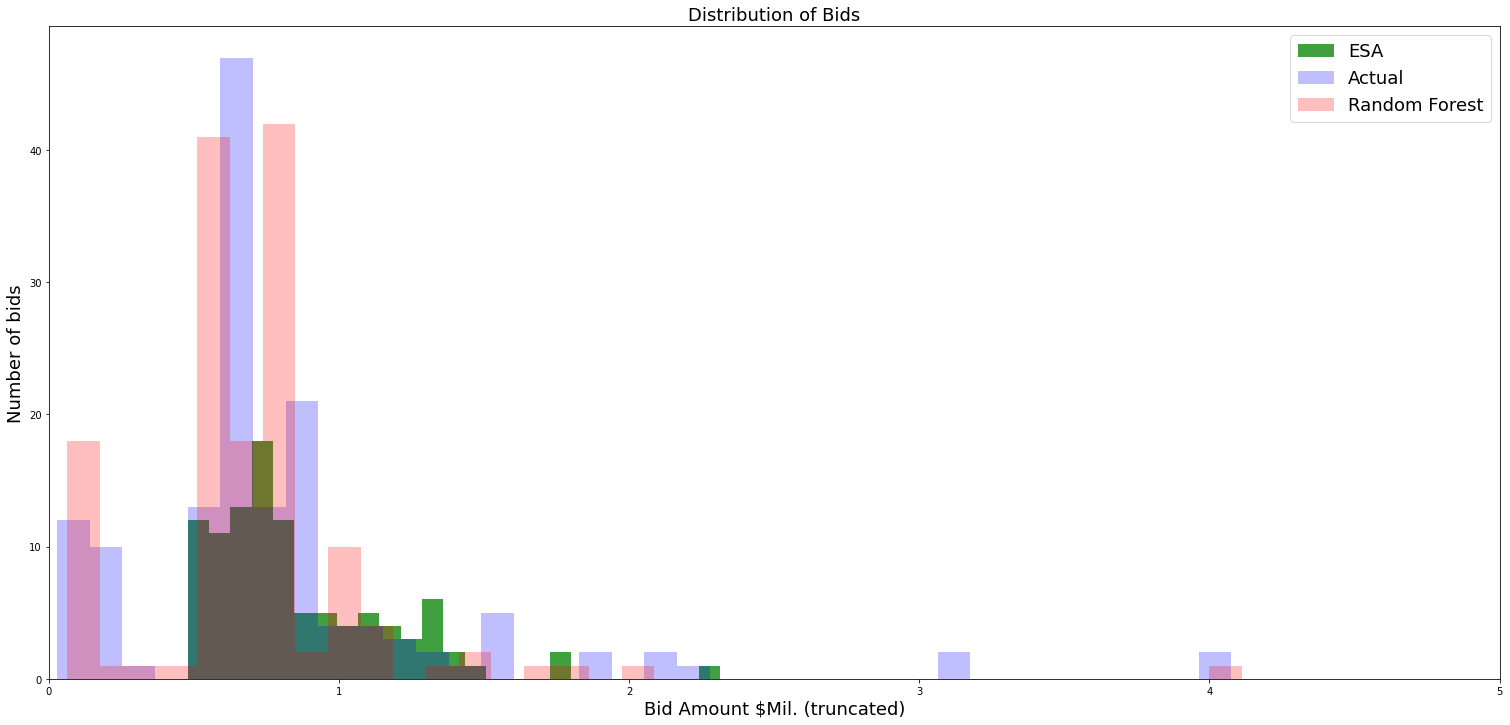

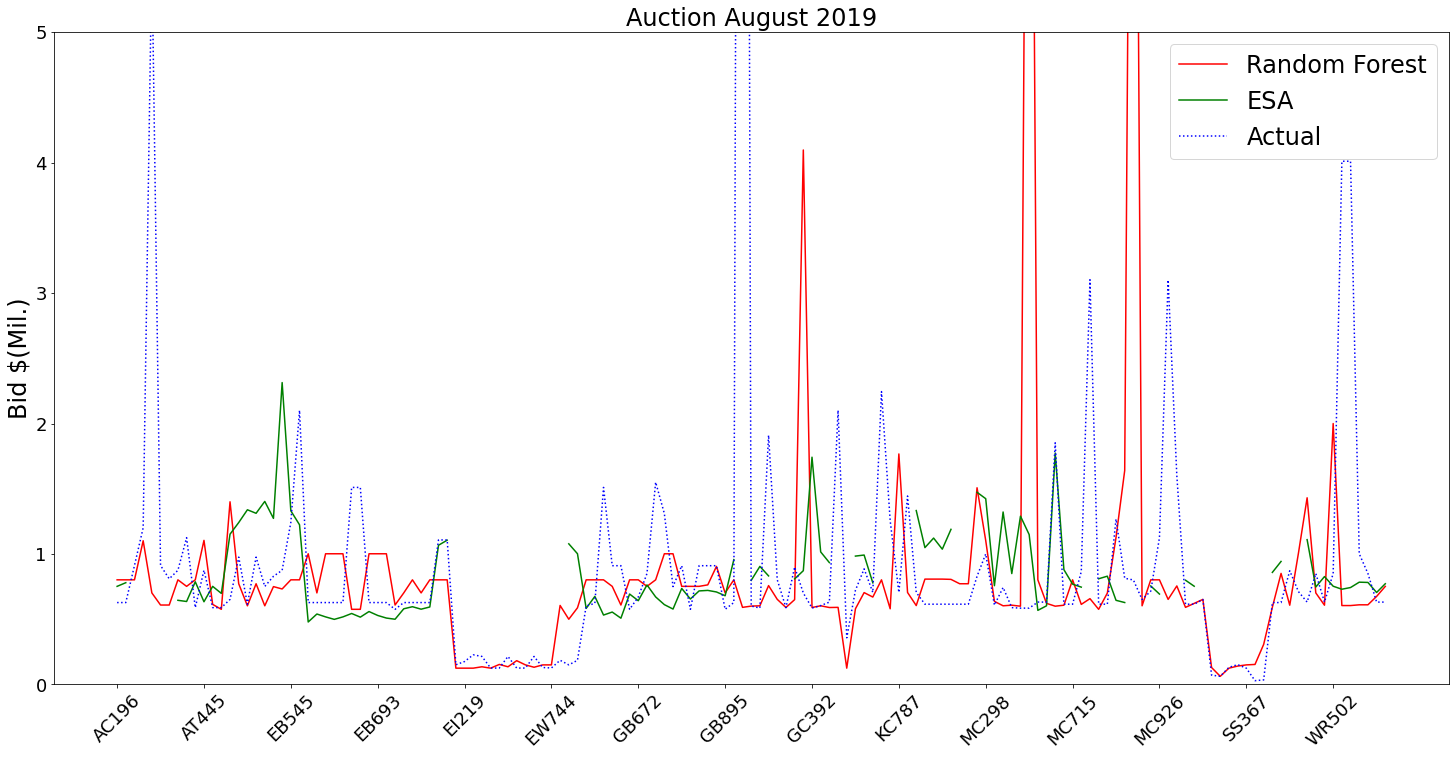

In [107]:
import matplotlib.pylab as plt
plt.figure(figsize=(26,12))
plt.hist(esa_pred,25, alpha=0.75, color='green')
plt.hist(_yp/1E+6, 200, alpha=0.25, color='blue')
plt.hist(clfrf.predict(scaler.transform(_Xp))/1E+6, 100, alpha=0.25, color='red')
plt.xlim([0,5])
plt.xlabel("Bid Amount $Mil. (truncated)", fontsize=18)
plt.ylabel("Number of bids", fontsize=18)
plt.title("Distribution of Bids", fontsize=18)
plt.legend(["ESA",  "Actual", "Random Forest"], fontsize=18)
plt.show()

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

ax.plot(clfrf.predict(scaler.transform(_Xp))/1E+6, '-r')
ax.plot(esa_pred, '-g')
ax.plot(_yp/1E+6, ':b')

ax.set_ylim([0,5])
ax.set_xticklabels(_mlot["AREABLK"].values[::10], fontsize=18, rotation=45)
ax.set_xticks(np.arange(0,len(_mlot["AREABLK"]), 10))
plt.yticks(fontsize=18)
plt.ylabel("Bid $(Mil.)", fontsize=24)
plt.legend(["Random Forest","ESA","Actual"], fontsize=24)
plt.title("Auction August 2019", fontsize=24)

plt.show()

In [108]:
_mlot["Pred-RF"] = clfrf.predict(scaler.transform(_Xp))
_mlot["Pred-Ln"] = np.round(clf.predict(scaler.transform(_Xp)),0)
_mlot["Pred-LogLn"] = np.round(clfln.predict(scaler.transform(_Xp)),0)
_mlot["Pred-ESA"] = np.round(esa_pred*1E+6,0)

for i,feat in enumerate(features):
    _mlot[feat] = _Xp[:,i]
    
_mlot.to_csv(join(base_directory, "model-1", "pred-rf-aug19.csv"))

In [109]:
_X = np.vstack([np.load(join(base_directory, "model-1", "X-{}.npy".format(i))) 
                        for i in range(23,31)])
_y = np.hstack([np.load(join(base_directory, "model-1", "y-{}.npy".format(i))) 
                        for i in range(23,31)])

_Xp = np.load(join(base_directory, "model-1", "X-{}.npy".format(31)))
_yp = np.load(join(base_directory, "model-1", "y-{}.npy".format(31)))
_mlot = pd.read_csv(join(base_directory, "model-1", "bids-{}.csv".format(31)))

_X = np.ascontiguousarray(_X)
_y = np.ascontiguousarray(_y)

scaler = RobustScaler()
_X = scaler.fit_transform(_X)

clf =  LinearRegression()
clf.fit(_X, _y)

# min value per block
indx = _y > 1E+5
_Xln = _X[indx,:]
_yln = np.log(_y[indx] - 1E+5)

clfln =  LinearRegression()
clfln.fit(_Xln, _yln)

#
clfrf = RandomForestClassifier(random_state=42)
clfrf.fit(_X.astype(np.float32), _y.astype(np.float32))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

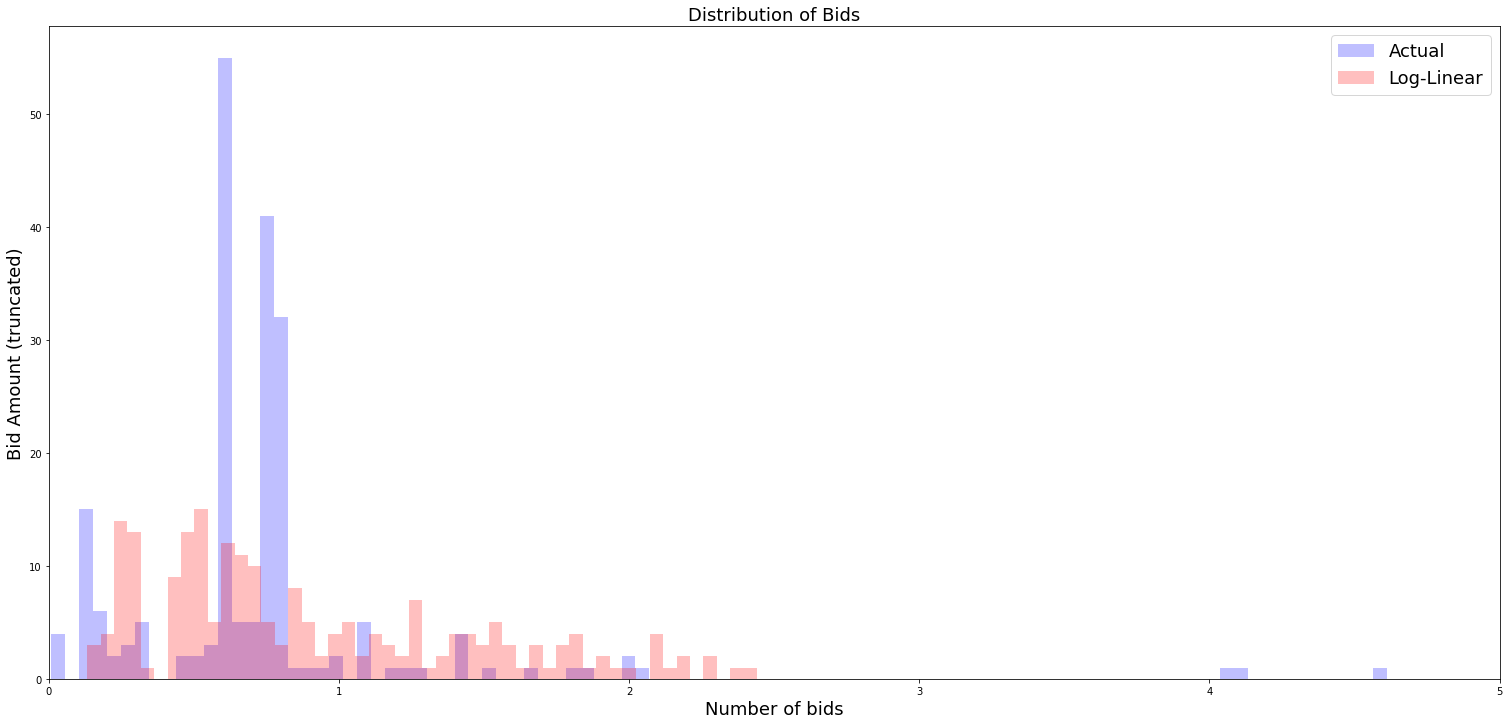

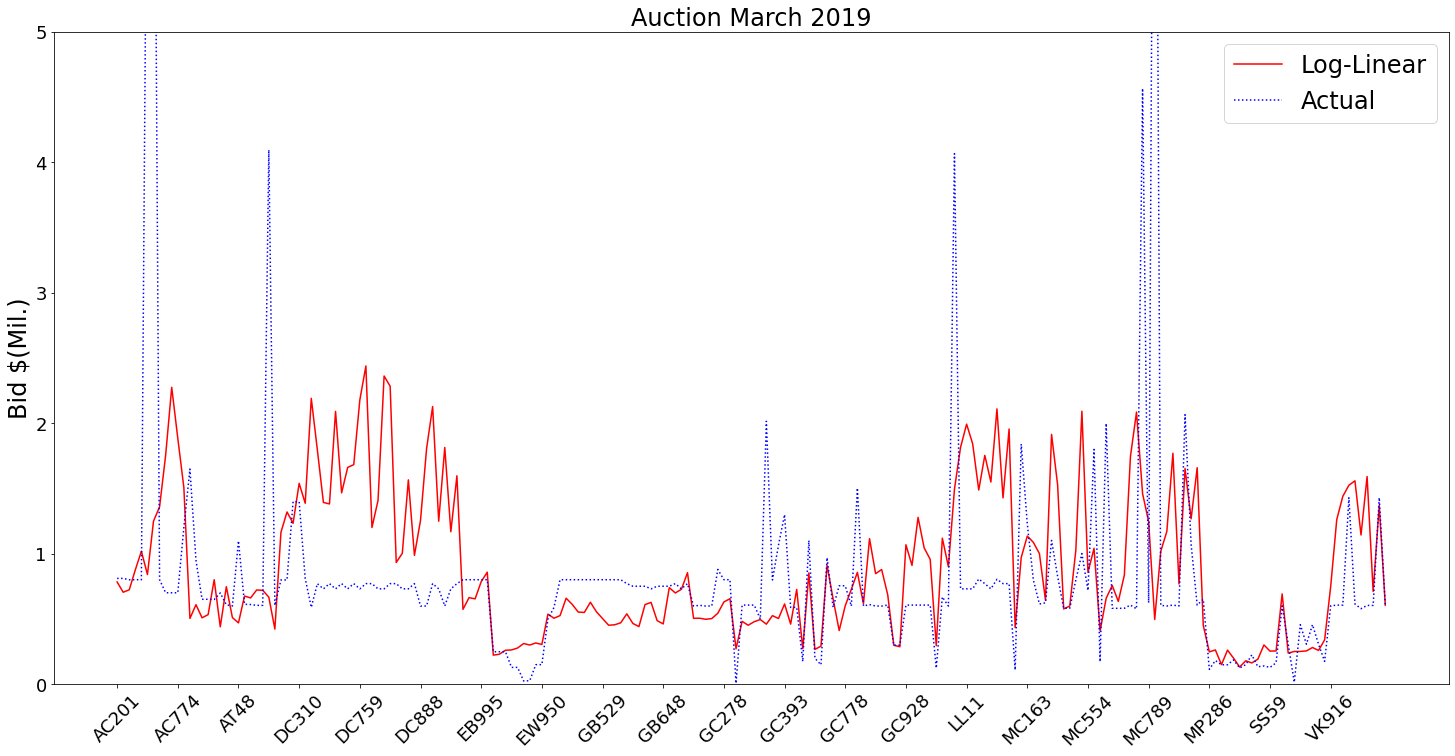

In [96]:
import matplotlib.pylab as plt

val = np.exp(clfln.predict(scaler.transform(_Xp))) + 1E+5

plt.figure(figsize=(26,12))
plt.hist(_yp/1E+6, 200, alpha=0.25, color='blue')
plt.hist(val/1E+6, 50, alpha=0.25, color='red')
plt.xlim([0,5])
plt.xlabel("Bid Amount $Mil. (truncated)", fontsize=18)
plt.ylabel("Number of bids", fontsize=18)
plt.title("Distribution of Bids", fontsize=18)
plt.legend(["Actual", "Log-Linear"], fontsize=18)
plt.show()

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

ax.plot(val/1E+6, '-r')
ax.plot(_yp/1E+6, ':b')

ax.set_ylim([0,5])
ax.set_xticklabels(_mlot["AREABLK"].values[::10], fontsize=18, rotation=45)
ax.set_xticks(np.arange(0,len(_mlot["AREABLK"]), 10))
plt.yticks(fontsize=18)
plt.ylabel("Bid $(Mil.)", fontsize=24)
plt.legend(["Log-Linear","Actual"], fontsize=24)
plt.title("Auction March 2019", fontsize=24)

plt.show()

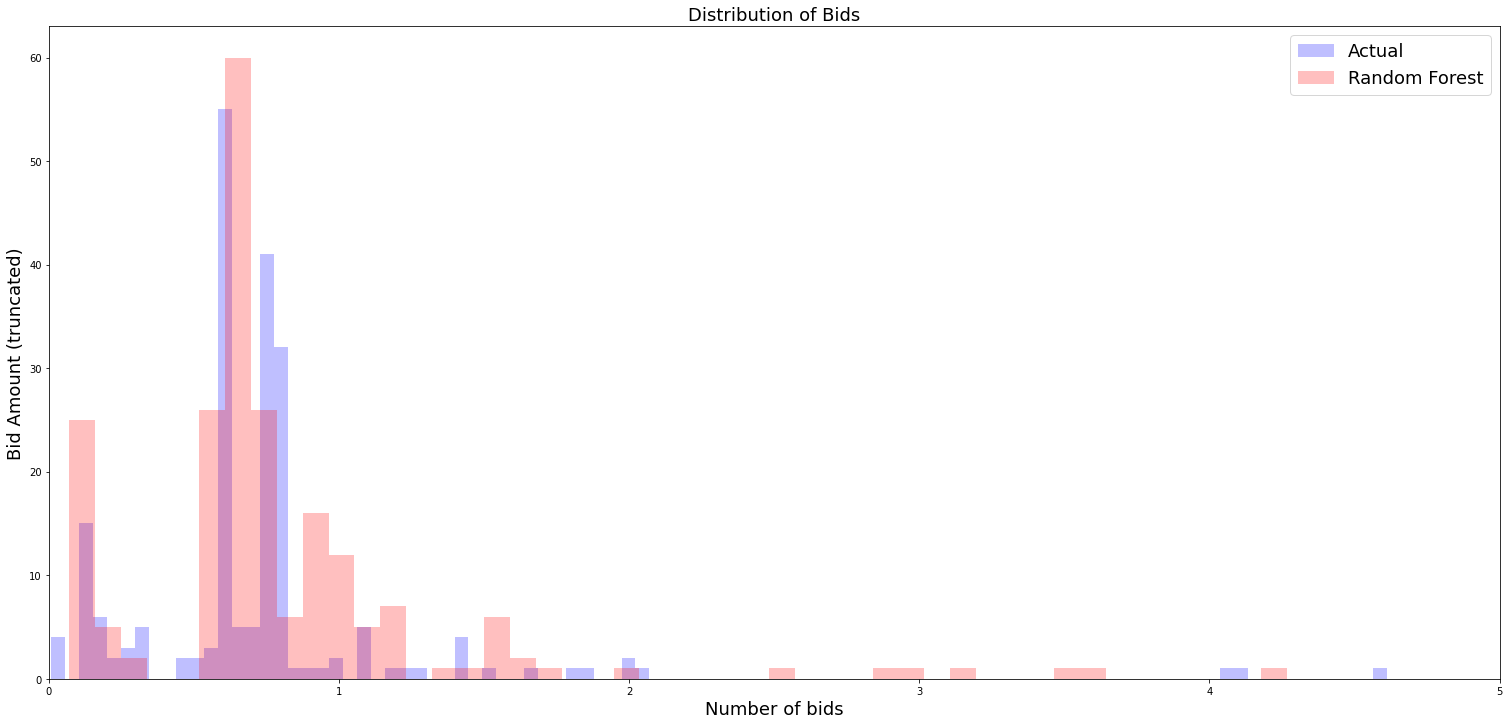

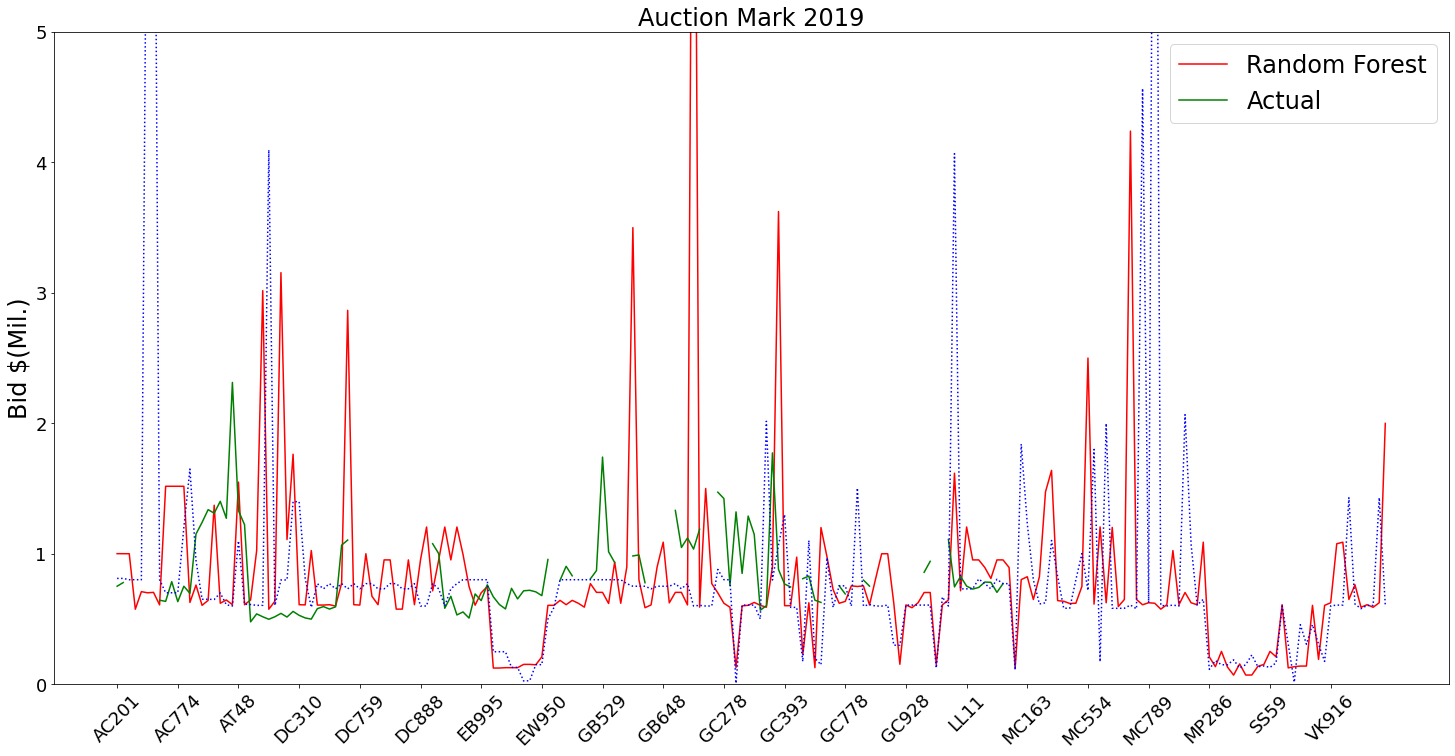

In [97]:
import matplotlib.pylab as plt

val = clfrf.predict(scaler.transform(_Xp))

plt.figure(figsize=(26,12))
plt.hist(_yp/1E+6, 200, alpha=0.25, color='blue')
plt.hist(val/1E+6, 100, alpha=0.25, color='red')
plt.xlim([0,5])
plt.xlabel("Bid Amount (truncated)", fontsize=18)
plt.ylabel("Number of bids", fontsize=18)
plt.title("Distribution of Bids", fontsize=18)
plt.legend(["Actual", "Random Forest"], fontsize=18)
plt.show()

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

ax.plot(val/1E+6, '-r')
ax.plot(esa_pred, '-g')
ax.plot(_yp/1E+6, ':b')

ax.set_ylim([0,5])
ax.set_xticklabels(_mlot["AREABLK"].values[::10], fontsize=18, rotation=45)
ax.set_xticks(np.arange(0,len(_mlot["AREABLK"]), 10))
plt.yticks(fontsize=18)
plt.ylabel("Bid $(Mil.)", fontsize=24)
plt.legend(["Random Forest","Actual"], fontsize=24)
plt.title("Auction Mark 2019", fontsize=24)

plt.show()